# Import Libraries

In [ ]:
import os
import random
import shutil
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Counting Images in Dataset Folders

In [5]:
import os
from pathlib import Path

# Define the path to your main dataset folder
dataset_folder = r'C:\Users\Lap Top\dataset'

# Function to count images in each class folder
def count_images_in_folders(dataset_folder):
    for class_dir in Path(dataset_folder).iterdir():
        if class_dir.is_dir():  # Check if it's a directory
            image_count = len(list(class_dir.glob('*.*')))  # Count all files (images) in the folder
            print(f"Class '{class_dir.name}': {image_count} images")

# Call the function
count_images_in_folders(dataset_folder)

Class 'Fake': 10330 images
Class 'Real': 8288 images


# Splitting Data into Train, Validation, and Test Sets

In [16]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# Define paths
dataset_folder = r'C:\Users\Lap Top\Art\dataset'
output_folder = r'C:\Users\Lap Top\Art\split_dataset'

# Create output directories for train, validation, and test
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'validation')
test_dir = os.path.join(output_folder, 'test')

# Create directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    # Create subdirectories for each class
    os.makedirs(os.path.join(dir_path, 'Fake'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'Real'), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Process each class
for class_name in ['Fake', 'Real']:
    class_dir = os.path.join(dataset_folder, class_name)
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    # First split: separate train from the rest
    train_files, temp_files = train_test_split(image_files, train_size=train_ratio, random_state=42)
    
    # Second split: divide the rest into validation and test
    # Adjust the test_size to get the desired ratio
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)
    
    # Copy files to respective directories
    for file_name in train_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(train_dir, class_name, file_name)
        shutil.copy2(src, dst)
    
    for file_name in val_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(val_dir, class_name, file_name)
        shutil.copy2(src, dst)
    
    for file_name in test_files:
        src = os.path.join(class_dir, file_name)
        dst = os.path.join(test_dir, class_name, file_name)
        shutil.copy2(src, dst)
    
    # Print statistics
    print(f"Class '{class_name}':")
    print(f"  Total: {len(image_files)} images")
    print(f"  Train: {len(train_files)} images ({len(train_files)/len(image_files)*100:.1f}%)")
    print(f"  Validation: {len(val_files)} images ({len(val_files)/len(image_files)*100:.1f}%)")
    print(f"  Test: {len(test_files)} images ({len(test_files)/len(image_files)*100:.1f}%)")

print("\nSplit complete!")

Class 'Fake':
  Total: 10330 images
  Train: 7230 images (70.0%)
  Validation: 1550 images (15.0%)
  Test: 1550 images (15.0%)
Class 'Real':
  Total: 8288 images
  Train: 5801 images (70.0%)
  Validation: 1243 images (15.0%)
  Test: 1244 images (15.0%)

Split complete!


# Define paths to your directories

In [17]:
train_dir = pathlib.Path(r"C:\Users\Lap Top\split_dataset\train")
val_dir = pathlib.Path(r"C:\Users\Lap Top\split_dataset\validation")
test_dir = pathlib.Path(r"C:\Users\Lap Top\split_dataset\test")

# Function to view random images from specified classes

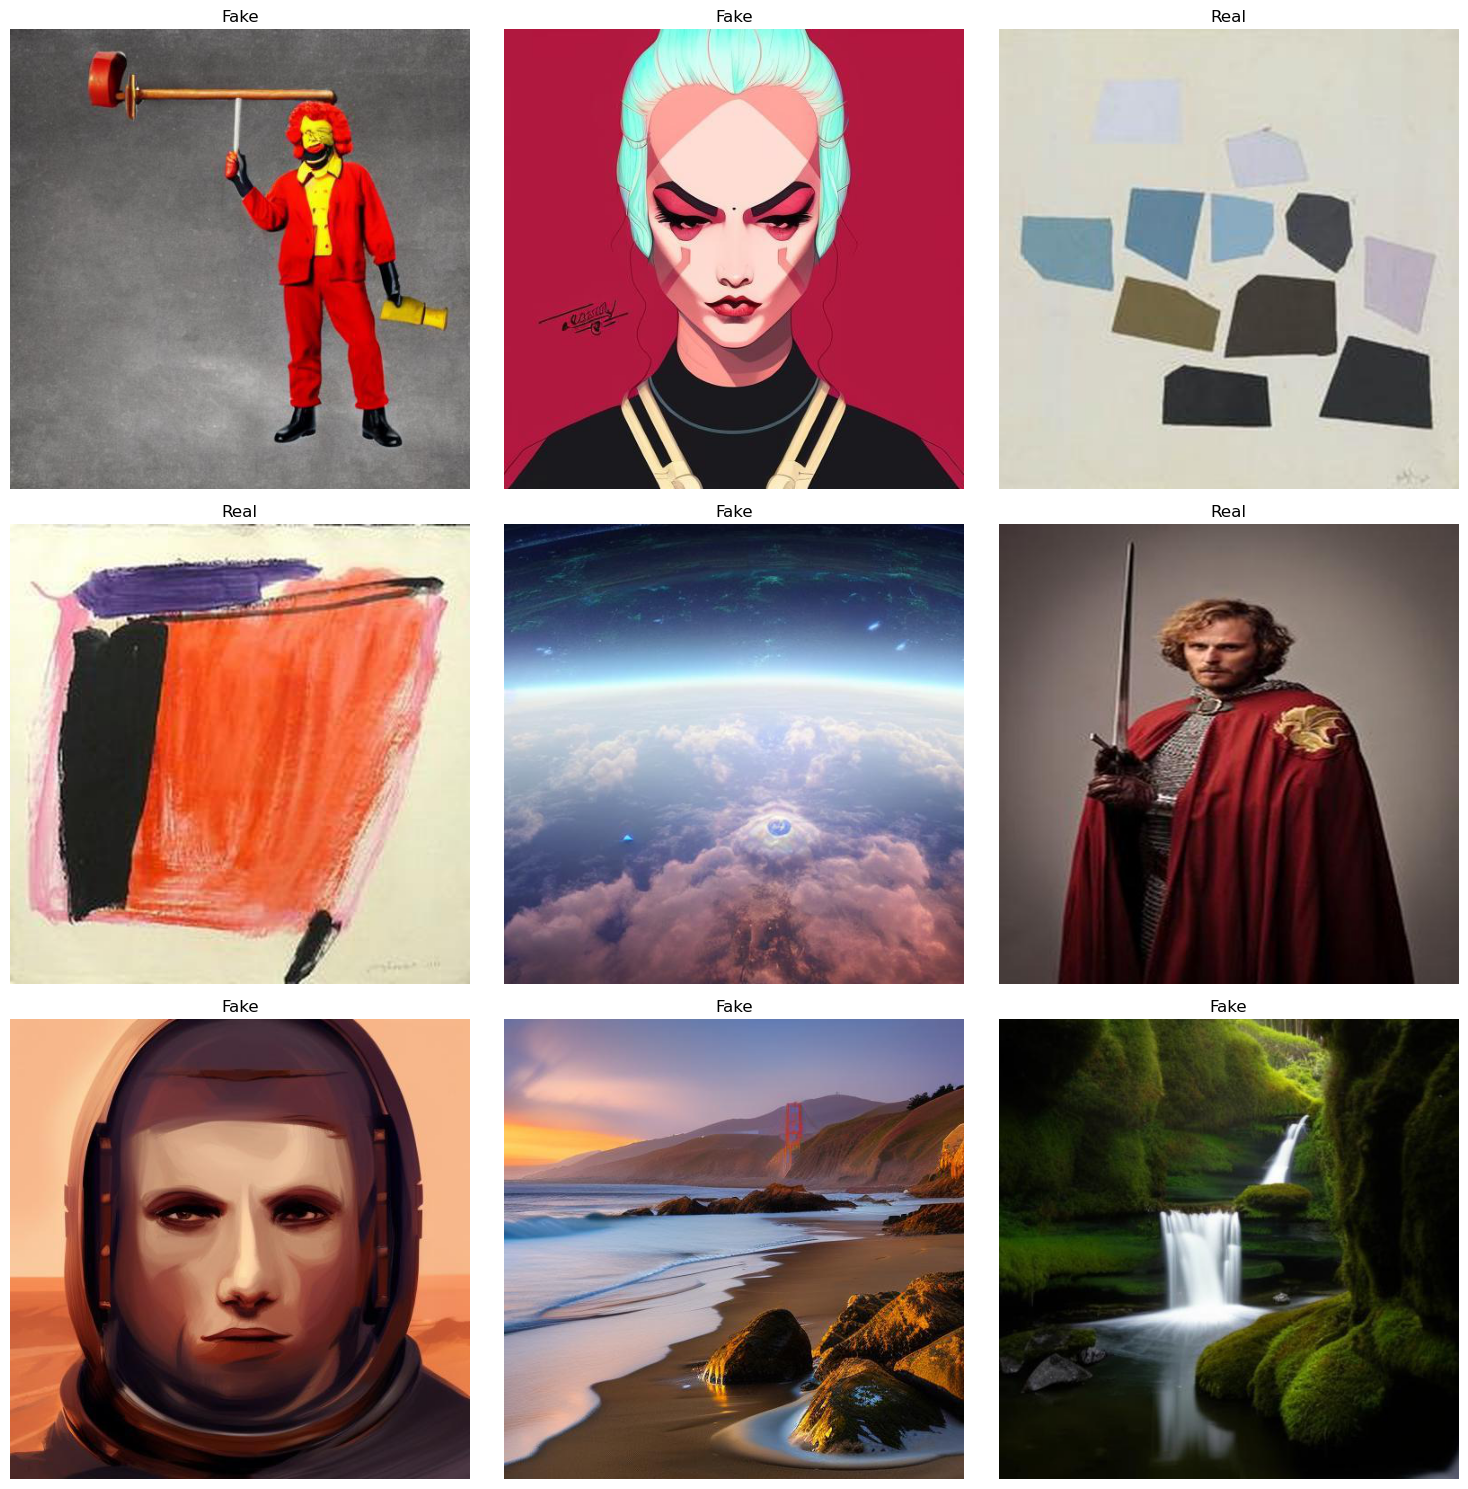

In [19]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path  

def view_random_images(target_dir: Path, target_classes: list, num_images: int = 9):
    """View a specified number of random images from a list of target classes."""
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        target_class = random.choice(target_classes)
        target_folder = target_dir / target_class  # Use Path object for joining
        all_images = [f.name for f in target_folder.iterdir() if f.is_file()] # Use Path object methods
        if all_images:
            random_image = random.choice(all_images)
            img_path = target_folder / random_image # Use Path object for joining
            img = mpimg.imread(img_path)
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(target_class)
            plt.axis('off')
        else:
            print(f"No images found in class: {target_class}")
    plt.tight_layout()
    plt.show()


view_random_images(target_dir=train, target_classes=["Real", "Fake"], num_images=9)

# Create ImageDataGenerators for data augmentation and loading

In [47]:
# Parameters
image_height, image_width = 224, 224
batch_size = 32
num_epochs = 16

# Data augmentation for training
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Data generators
training_data_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_data_generator = validation_data_generator.flow_from_directory(
    val_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

testing_data_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important for confusion matrix
)

Found 13031 images belonging to 2 classes.
Found 2793 images belonging to 2 classes.
Found 2794 images belonging to 2 classes.


# Building an AI Image Classification Model with MobileNetV2

In [23]:
# Create the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-tr

# Training the AI Image Detection Model with Callbacks

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss)
    patience=8,         t
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Define ModelCheckpoint callback to save the best weights
checkpoint_filepath = 'AI_Image_Detector.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Only save the model with the best validation loss
    monitor='val_loss',
    mode='min',          # 'min' because we want to minimize validation loss
    save_weights_only=False # Save the entire model (architecture + weights)
)


num_epochs = 30  

# Train the model with EarlyStopping and ModelCheckpoint
training_history = model.fit(
    training_data_generator,
    steps_per_epoch=training_data_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.samples // batch_size,
    callbacks=[early_stopping_callback, model_checkpoint_callback]  
)

print(f"\nTraining finished. The best model weights (based on validation loss) have been saved to {checkpoint_filepath}")

Epoch 1/30
407/407 [==============================] - 213s 524ms/step - loss: 0.2336 - accuracy: 0.9003 - val_loss: 0.2900 - val_accuracy: 0.8754
Epoch 2/30
407/407 [==============================] - 227s 557ms/step - loss: 0.2211 - accuracy: 0.9059 - val_loss: 0.3066 - val_accuracy: 0.8710
Epoch 3/30
407/407 [==============================] - 225s 552ms/step - loss: 0.2216 - accuracy: 0.9057 - val_loss: 0.2540 - val_accuracy: 0.8940
Epoch 4/30
407/407 [==============================] - 223s 549ms/step - loss: 0.2154 - accuracy: 0.9075 - val_loss: 0.3196 - val_accuracy: 0.8693
Epoch 5/30
407/407 [==============================] - 226s 556ms/step - loss: 0.2149 - accuracy: 0.9086 - val_loss: 0.2579 - val_accuracy: 0.8926
Epoch 6/30
407/407 [==============================] - 237s 583ms/step - loss: 0.2028 - accuracy: 0.9145 - val_loss: 0.3406 - val_accuracy: 0.8603
Epoch 7/30
407/407 [==============================] - 266s 653ms/step - loss: 0.2127 - accuracy: 0.9127 - val_loss: 0.3020 -

# Evaluate the model on the test dataset

In [50]:
evaluation_loss, evaluation_accuracy = model.evaluate(testing_data_generator)  
print(f"Test Accuracy: {evaluation_accuracy:.2f}") 
print(f"Test Loss: {evaluation_loss:.2f}")  

88/88 [==============================] - 9s 106ms/step - loss: 0.2715 - accuracy: 0.8851
Test Accuracy: 0.89
Test Loss: 0.27


# Plotting Training and Validation Accuracy/Loss

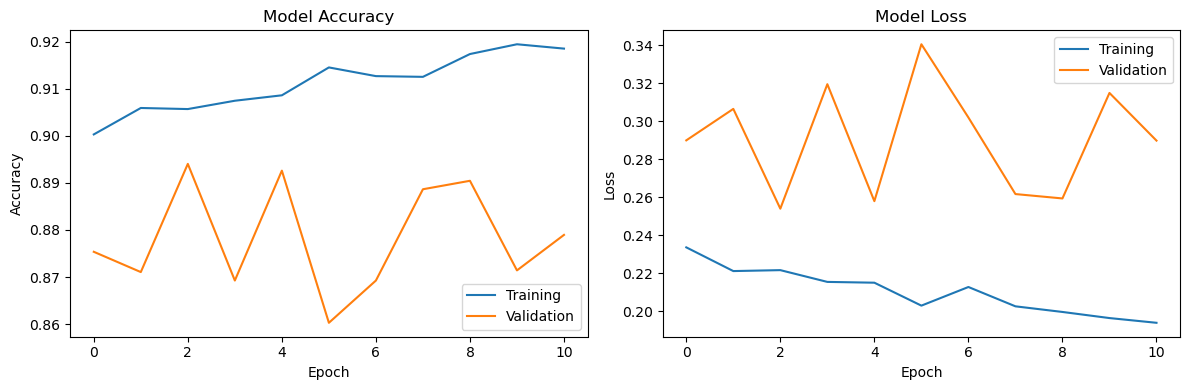

In [51]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])  
plt.plot(training_history.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')  

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss']) 
plt.plot(training_history.history['val_loss'])  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')  
plt.tight_layout()
plt.savefig('training_history.png') 
plt.show()

# Model Evaluation

88/88 [==============================] - 9s 101ms/step - loss: 0.2715 - accuracy: 0.8851
Test accuracy: 0.8851
Test loss: 0.2715
88/88 [==============================] - 9s 101ms/step

Classification Report:
              precision    recall  f1-score   support

        Fake       0.84      0.98      0.90      1550
        Real       0.96      0.77      0.86      1244

    accuracy                           0.89      2794
   macro avg       0.90      0.87      0.88      2794
weighted avg       0.90      0.89      0.88      2794



<Figure size 800x800 with 0 Axes>

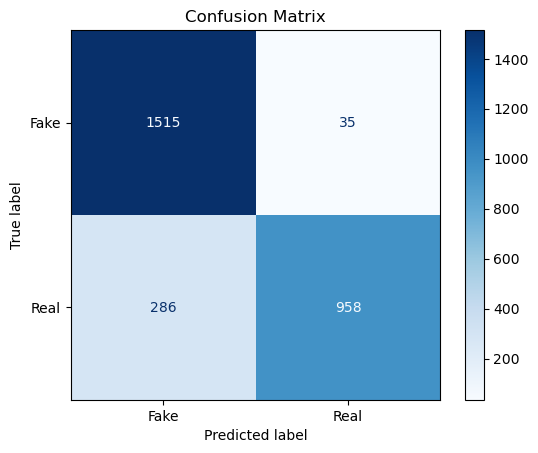

In [52]:
# Evaluate model on test set
evaluation_loss, evaluation_accuracy = model.evaluate(testing_data_generator)  
print(f"Test accuracy: {evaluation_accuracy:.4f}")  
print(f"Test loss: {evaluation_loss:.4f}")  

# Get predictions for confusion matrix and classification report
model_predictions = model.predict(testing_data_generator)  
predicted_classes = (model_predictions > 0.5).astype(int)  
true_classes = testing_data_generator.classes  

# Generate classification report
class_labels = list(testing_data_generator.class_indices.keys()) 
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))  

# Generate confusion matrix
confusion_matrix_values = confusion_matrix(true_classes, predicted_classes)  
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_values, display_labels=class_labels) 
plt.figure(figsize=(8, 8))
confusion_matrix_display.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  
plt.show()